[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbwilburn/CHEM7150/blob/main/Intro_to_Neural_Networks_SP24.ipynb)

## <b>Chem7150 Advanced Mass Spectrometry</b>
## <i>Data informatics and machine learning</i>


This Jupyter notebook is intended as a brief introduction to neural networks as universal approximators for non-linear relationships.


Import required Python libraries for additional functionality (particularly PyTorch for machine learning)

In [1]:
## Required libraries
import math, time
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader


#### To illustrate how neural networks can approximate non-linear relationships, let's define a fairly complicated non-linear curve that relates a single input <b><i>x</i></b> to a single output <b><i>y</i></b> or <b><i>f(x)</i></b>. In this instance, it is the sum of multiple oscillating waves similar to the type of raw data produced by Orbitrap/FT-ICR mass spectrometers


### $f(x)=3\sin{\frac{x}{0.5}}+8\sin{\frac{x}{1.0}}+5\sin{\frac{x}{2.0}}+12\sin{\frac{x}{0.25}}$

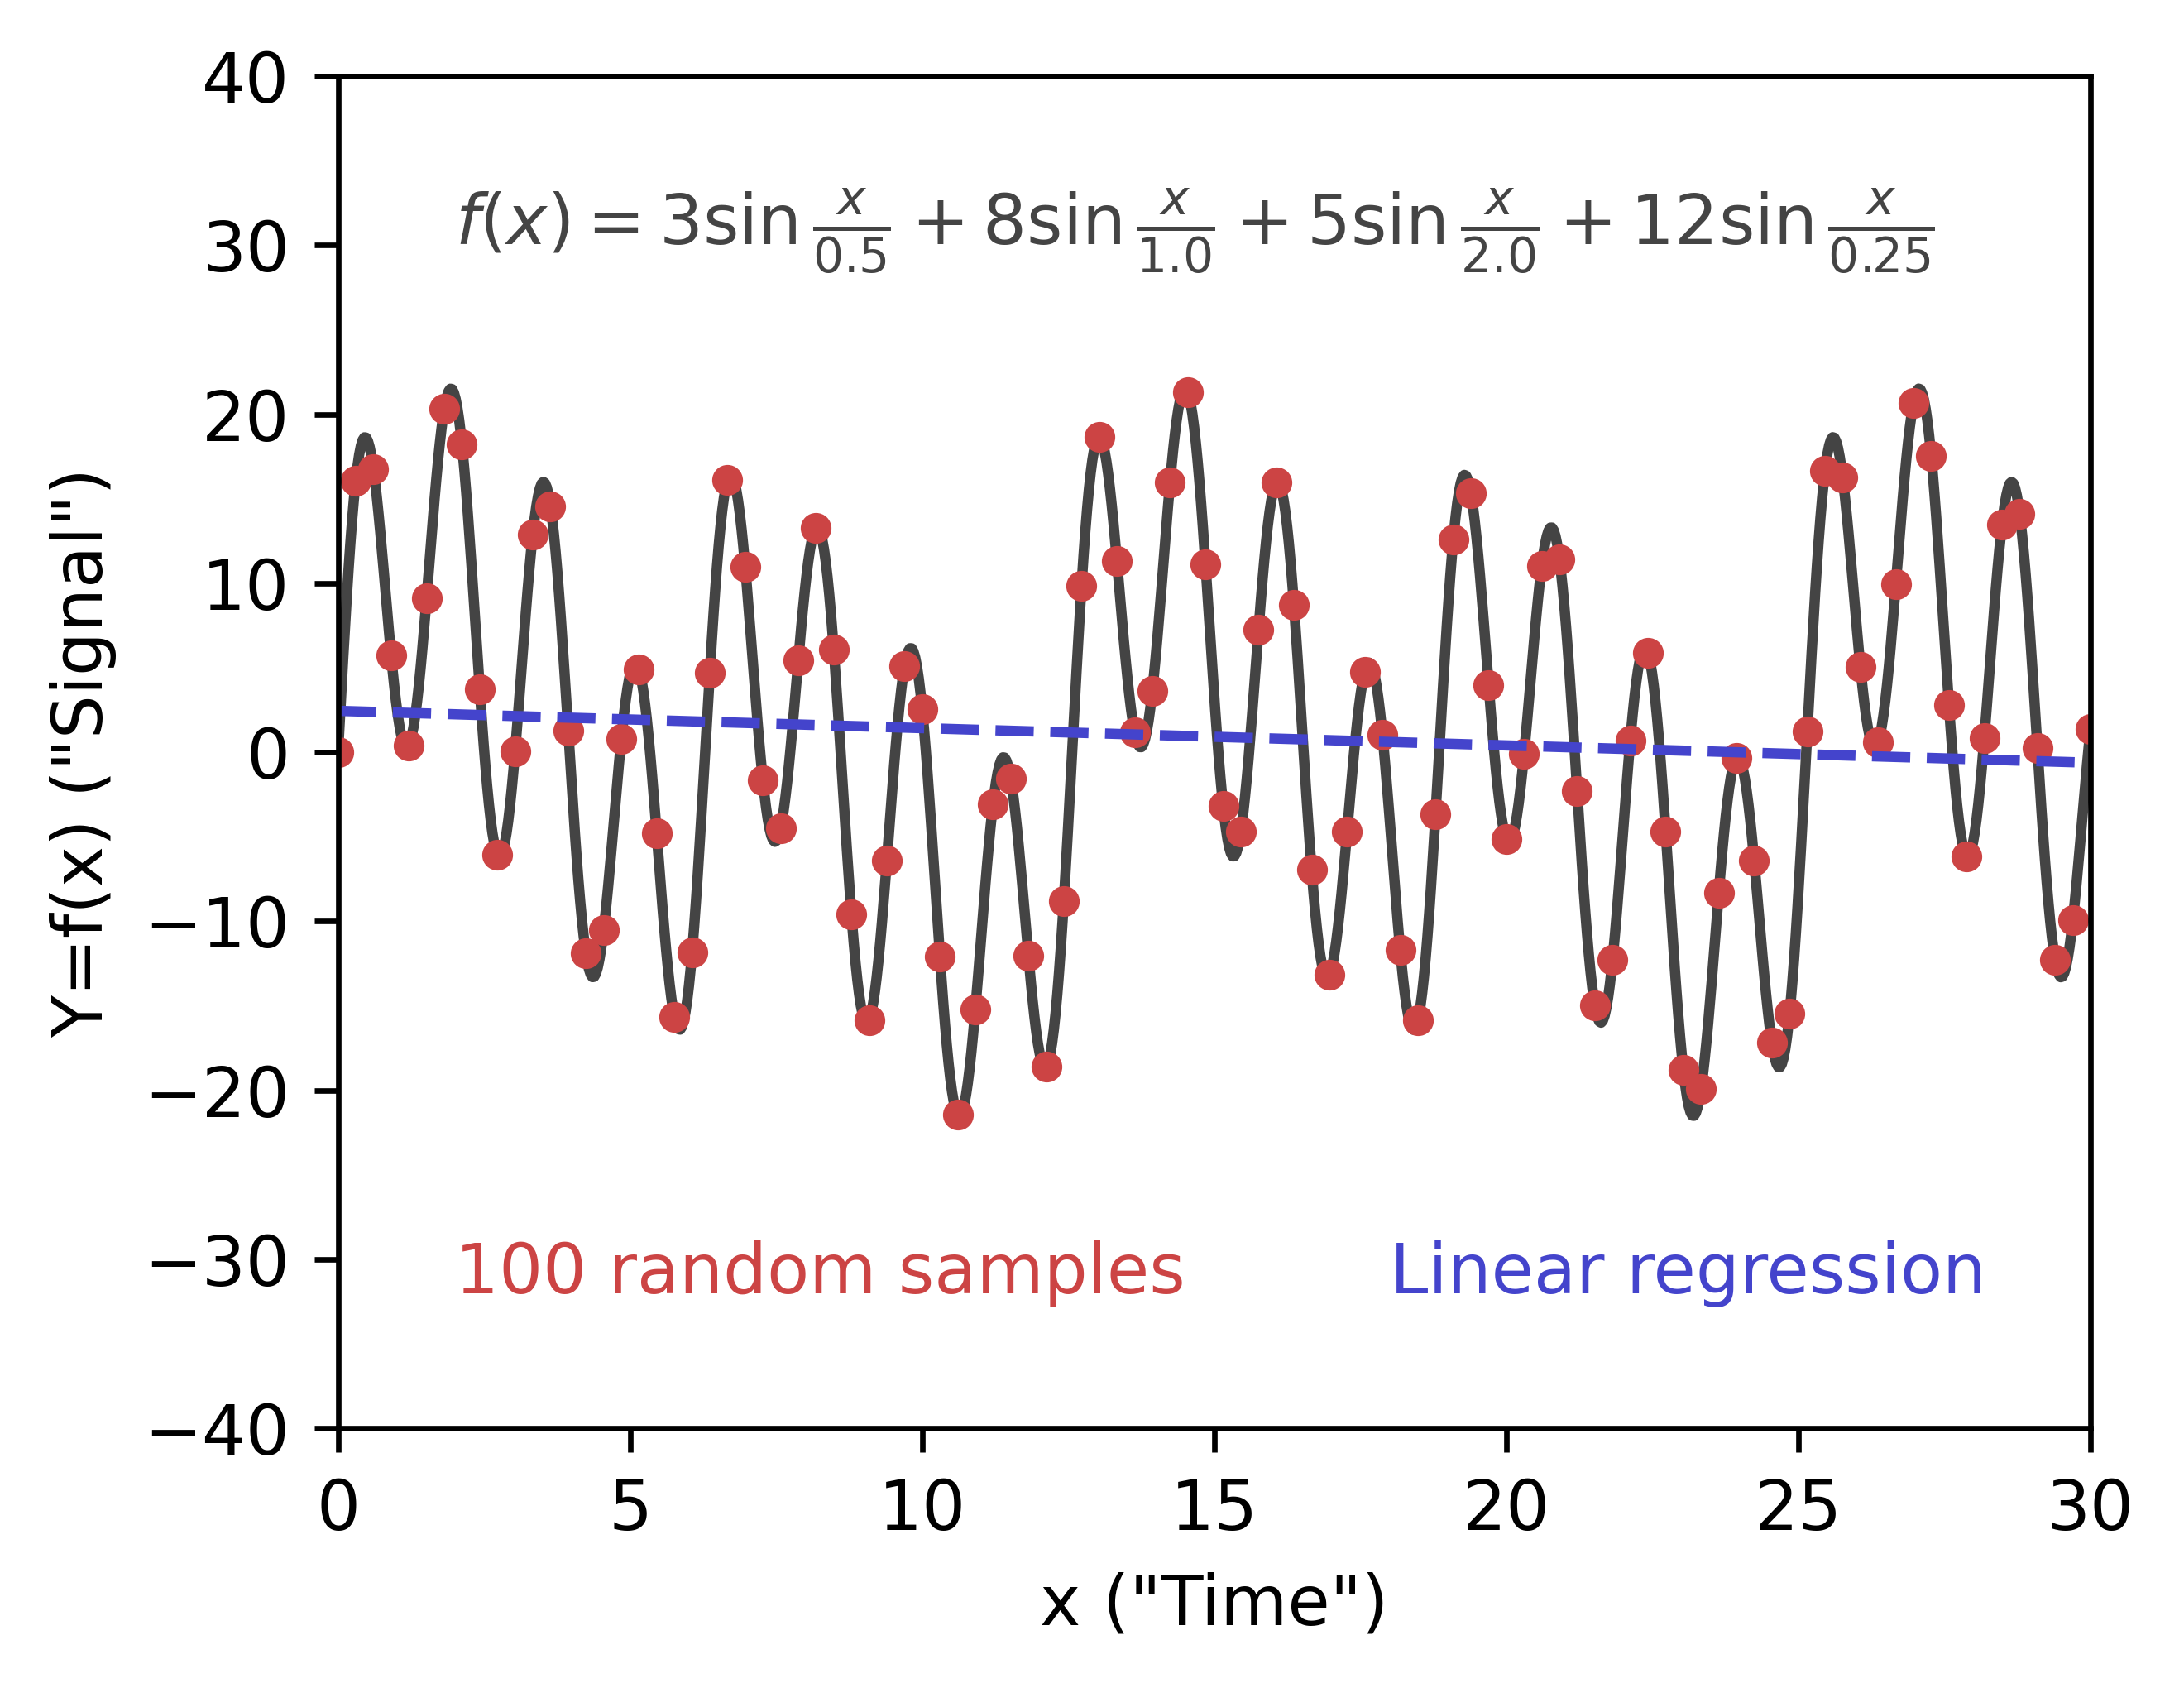

In [2]:
## Define f(x)
def f(x):
    #return 1/3*x**2 -x + 10*np.sin(x)
    # Equivalent to 3*sin(x/0.5) + 8*sin(x) + 5*sin(x/2) + 12*sin(x/0.25)
    weights = np.array([[3, 8, 5, 12]])
    periods = np.array([[0.5, 1, 2, 0.25]])
    return np.sum(weights*np.sin(x.reshape((-1,1))/periods), axis=1)


## Plot the curve
xlim = (0,30)
ylim = (-40,40)
xt = np.linspace(*xlim, 1000)
yt = f(xt)

x_pts = np.linspace(*xlim, 100)
y_pts = f(x_pts)
m, b, r, p, se = stats.linregress(x_pts, y_pts)


fig, ax = plt.subplots(figsize=(4.5,3.5), dpi=600)
ax.plot(xt, yt, color='#444444', zorder=0)
ax.scatter(x_pts, y_pts, s=12, color='#cc4444')
ax.plot(x_pts, m*x_pts+b, linestyle='dashed', color='#4444cc')
ax.set(xlim=xlim, ylim=ylim)

ax.text(2, 30, r'$f(x)=3\sin{\frac{x}{0.5}}+8\sin{\frac{x}{1.0}}+5\sin{\frac{x}{2.0}}+12\sin{\frac{x}{0.25}}$', fontsize=10, color='#444444')
ax.text(2, -32, '100 random samples', fontsize=10, color='#cc4444')
ax.text(18, -32, 'Linear regression', fontsize=10, color='#4444cc')
ax.set_xlabel('x ("Time")')
ax.set_ylabel('Y=f(x) ("Signal")')
fig.tight_layout()


## The code below constructs a simple Multilayer Perceptron (MLP) that stacks linear transforms with batch normalization and ReLU activation. Sampling functions are included to generate variable amounts of test data, process into tensors, and train a specified MLP.

In [3]:
## Code to define the neural network architecture and training routines

class MLP(nn.Module): 
    '''
    MLP = Multi-Layer Perceptron
    A common type of neural network with linear connections between
    neurons followed by an activation function. In this instance, we
    will use the Rectified Linear Unit (ReLU) activation function.
    '''
    def __init__(self, n_layers=0, hidden_neurons=1):
        super().__init__()
        param_size = 1
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            self.layers.append(nn.Linear(param_size,hidden_neurons))
            self.layers.append(nn.BatchNorm1d(hidden_neurons))
            self.layers.append(nn.ReLU())
            param_size = hidden_neurons
        self.layers.append(nn.Linear(param_size,1))

    def forward(self, x):
        #return self.layers(x)
        for l in self.layers:
            x = l(x)
        return x
    

def generate_sample_data(n_samples:int,
                         x_min:float,
                         x_max:float,
                         batch_size:int,
                         seed:int = None):
    '''
    Generate random x/y data using f(x), returns a PyTorch DataLoader
    for iterable generation of data. Set the seed for deterministic
    results.
    '''
    
    # Define seed if not provided
    if not seed:
        seed = int(time.time())

    # Compute random x and y values as training data
    rng = np.random.default_rng(seed)
    sample_x = rng.uniform(x_min, x_max, n_samples)
    sample_y = f(sample_x)

    # Convert to tensors and prepare mini-batches for training
    dataset = TensorDataset(*[torch.tensor(v).reshape((-1,1)).to(torch.float32) for v in [sample_x, sample_y]])
    

    return dataset

def generate_dataloader(dataset, 
                        batch_size:int, 
                        seed:int = None,
                        shuffle=True):
    if not seed:
        seed = int(time.time())
    g_cpu = torch.Generator()
    g_cpu.manual_seed(3*seed+1) # Set to ensure reproducible results
    dataloader = DataLoader(dataset, batch_size, shuffle=shuffle, generator=g_cpu)
    return dataloader


def compute_model_error(model:nn.Module, 
                        error_fx:nn.Module,
                        x_min:float, 
                        x_max:float, 
                        n_points:int):
    '''
    Compute Pearson correlation of model relative to a defined domain
    '''

    x_range = x_max - x_min
    x_tensor = torch.linspace(x_min, x_max, n_points).reshape((-1,1))
    y_tensor = torch.tensor(f(x_tensor.detach().numpy()))
    pred = model(x_tensor)
    error = error_fx(pred, y_tensor.reshape((-1,1))).item()
    return pred.detach().numpy().flatten(), error



def generate_model_fit_figure(model_fit:np.array,
                              figsize:tuple,
                              dpi:int,
                              xlim:tuple,
                              ylim:tuple=(-40,40),
                              filename:str=None,
                              epoch:int=None,
                              error:float=None):
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    xt = np.linspace(*xlim, 1000)
    yt = f(xt)
    ax.plot(xt, yt, linewidth=5, color='#cccccc', label='True Relationship')
    ax.plot(xt, model_fit, linewidth=1, color='#cc4444', label='MLP')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set(xlim=xlim, ylim=ylim)
    ax.legend(loc='upper right')

    title = ''
    if epoch:
        title += f'Epoch {epoch}'
        if error:
            title += f' (MSE={error:.4f})'
    ax.set_title(title)
    fig.tight_layout()

    if filename:
        fig.savefig(filename)
        plt.close()

    else:
        return fig


def train_model(model, n_epochs, batch_size, n_samples, x_min, x_max, seed, score_res=1000, 
                epochs_to_double_bs=None, generate_figure=False, filename_prefix=None, 
                figsize=(4.5,3.5), dpi=600):
    '''
    Train model using Adam optimizer. Default learning rate = 0.001
    Our error or loss function is mean squared error (MSE).
    '''

    dataset = generate_sample_data(n_samples, x_min, x_max, batch_size, seed)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    #opt = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_fx = nn.MSELoss()
    model.train()
    for epoch in range(1, n_epochs+1):
        total_loss = 0 # will sum loss in each batch
        total_n = 0 # will sum n in each batch

        # Can adjust batch size during training to alter the learning rate and
        # potentially improve convergence towards a local optimum solution
        if not epochs_to_double_bs:
            bs = batch_size
        else:
            
            bs = 8*int(round(batch_size*math.pow(2.0, (epoch-1)/epochs_to_double_bs)/8.0))
        data = generate_dataloader(dataset, bs, seed+epoch, True)

        for i, batch in enumerate(data):
            # Compare model fits to expected y values
            x, y = batch
            pred = model(x)
            loss = loss_fx(pred, y)

            # Update epoch-level metrics
            batch_n = x.size(0) # Get batch size
            total_n += batch_n # Add batch n to total_n
            total_loss += loss.item()*batch_n # Add TOTAL batch loss to total_loss

            # Perform gradient (partial derivative-based) optimization of parameters
            opt.zero_grad() # Zero out the gradient
            loss.backward() # Compute the gradient relative to the loss
            opt.step() # Update model parameters accordingly

        epoch_loss = total_loss/total_n
        y_fit, epoch_mse = compute_model_error(model, loss_fx, x_min, x_max, score_res)
        print(f'Epoch {epoch}:\tMSE = {epoch_mse:.3}')

        if generate_figure:
            filename = filename_prefix+f'_Epoch_{epoch}.png' if filename_prefix else None
            generate_model_fit_figure(y_fit, figsize, dpi, (x_min,x_max), 
                                      filename=filename, epoch=epoch, error=epoch_mse)
        
        model.eval()
        
    return y_fit



## The example below uses 4 layers with 16 hidden neurons per layer with 500 epochs of training

In [4]:
n_layers = 4
n_neurons = 16
epochs = 500
batch_size = 32
data_size = int(2e4)
x_min = 0
x_max = 30
seed = 4996


torch.manual_seed(seed)
model = MLP(n_layers, n_neurons)
fit = train_model(model, epochs, batch_size, data_size, x_min, x_max, seed+1)
#                  generate_figure=True, filename_prefix='240416_')


Epoch 1:	MSE = 1.03e+02
Epoch 2:	MSE = 81.2
Epoch 3:	MSE = 70.6
Epoch 4:	MSE = 72.2
Epoch 5:	MSE = 61.0
Epoch 6:	MSE = 63.5
Epoch 7:	MSE = 55.1
Epoch 8:	MSE = 53.1
Epoch 9:	MSE = 49.1
Epoch 10:	MSE = 42.8
Epoch 11:	MSE = 39.9
Epoch 12:	MSE = 39.2
Epoch 13:	MSE = 35.0
Epoch 14:	MSE = 36.2
Epoch 15:	MSE = 30.6
Epoch 16:	MSE = 33.7
Epoch 17:	MSE = 31.4
Epoch 18:	MSE = 34.3
Epoch 19:	MSE = 34.1
Epoch 20:	MSE = 29.0
Epoch 21:	MSE = 26.3
Epoch 22:	MSE = 29.5
Epoch 23:	MSE = 28.2
Epoch 24:	MSE = 26.2
Epoch 25:	MSE = 25.7
Epoch 26:	MSE = 24.5
Epoch 27:	MSE = 28.0
Epoch 28:	MSE = 19.8
Epoch 29:	MSE = 21.0
Epoch 30:	MSE = 18.9
Epoch 31:	MSE = 25.1
Epoch 32:	MSE = 25.7
Epoch 33:	MSE = 22.2
Epoch 34:	MSE = 22.0
Epoch 35:	MSE = 20.5
Epoch 36:	MSE = 27.4
Epoch 37:	MSE = 22.3
Epoch 38:	MSE = 19.6
Epoch 39:	MSE = 21.7
Epoch 40:	MSE = 24.3
Epoch 41:	MSE = 26.0
Epoch 42:	MSE = 19.2
Epoch 43:	MSE = 26.6
Epoch 44:	MSE = 19.8
Epoch 45:	MSE = 21.4
Epoch 46:	MSE = 20.5
Epoch 47:	MSE = 20.7
Epoch 48:	MSE = 22

In [ ]:
generate_model_fit_figure(fit, (4.5,3.5), 150, (0,30), 
                          filename=None, epoch=500, error=None)